In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv("filtered_dataset_positive.csv")
data

,date,Hour,Glw,Gsw,P_calculated_opt,P_measured,P_pvwatts_dc,T_PV,T_air,U,deltaT,eta,incidence angle,q_HFM,rend
0,2022-12-01,13,330.328272,36.189644,10.132362,2.585951,9.391419,8.781051,8.604278,1.552048,0.730765,220.444131,82.474122,-5.235680,0.043056
1,2022-12-01,14,328.779045,33.783313,9.458639,2.344498,8.775350,8.533828,8.425972,1.779009,0.691118,225.573360,86.961065,-7.129585,0.041272
2,2022-12-02,9,323.392700,30.944109,8.663719,1.942012,8.115113,6.105752,5.803407,0.732031,0.834625,194.088845,71.548634,-1.410699,0.036398
3,2022-12-02,10,327.879670,37.715279,10.559509,5.585719,9.889386,6.178521,5.986183,0.800093,0.702472,197.164897,70.720823,-7.787282,0.086813
4,2022-12-02,11,324.777322,72.537615,20.309052,15.277130,18.932246,6.887733,6.256926,0.996237,0.884729,174.501531,72.366243,8.043648,0.122049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,2023-11-25,12,306.732040,165.797941,46.420041,36.784258,42.615461,11.028779,8.152974,1.592258,3.169771,211.667136,75.405378,14.765534,0.135168
1145,2023-11-25,13,313.858308,104.978526,29.391846,22.778303,27.144657,9.490262,7.885907,1.739324,2.000227,226.705172,81.500345,3.440081,0.129377
1146,2023-11-25,14,294.669673,63.690080,17.831923,12.984059,16.625975,7.310226,7.211439,1.503094,0.389688,212.182064,89.097379,-5.531550,0.121735
1147,2023-11-25,15,287.333838,22.593514,6.325723,3.744434,5.925511,5.550171,6.553207,1.530555,-0.757335,249.005900,97.654891,-17.643555,0.093994


## PI-GAT Model

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
import os
import random

# =====================================================
# REPRODUCIBILITY FIX — set all random seeds
# =====================================================
def set_seed(seed=63):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(63)

# --------------------------
# Device
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Core configuration
# --------------------------
features = ['Glw', 'Gsw', 'T_PV', 'T_air', 'U', 'deltaT', 'q_HFM', 'cos_incidence_angle']
target = 'P_measured'

# --------------------------
# Load data
# --------------------------
data = pd.read_csv("filtered_dataset_positive.csv")
data['date'] = pd.to_datetime(data['date'])
data['cos_incidence_angle'] = np.cos(np.radians(data['incidence angle']))


C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
C:\Users\SM275008\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typin

Using device: cuda


In [3]:

# ==============================================================
# 1. Physics-informed edge weights
# ==============================================================

def compute_physics_edge_weights(row):
    """Computes the 4 physics-informed weights."""
    eps = 1e-6
    w1 = row['Gsw'] * row['cos_incidence_angle']               # Effective irradiance
    w2 = 1.0 / (row['deltaT'] + eps)                           # Temperature effect
    w3 = row['U'] * (row['deltaT'] + eps)                      # Wind cooling
    w4 = row['q_HFM'] / (row['deltaT'] + eps)                  # Heat flux interaction
    return [w1, w2, w3, w4]


# ==============================================================
# 2. Graph creation with edge normalization
# ==============================================================

def compute_edge_norm_stats(dataframe):
    """Compute mean/std of edge attributes for normalization (training window only)."""
    attrs = []
    for _, row in dataframe.iterrows():
        attrs.append(compute_physics_edge_weights(row))
    attrs = np.array(attrs)
    mean = np.mean(attrs, axis=0)
    std = np.std(attrs, axis=0) + 1e-6
    return mean, std


def create_physics_graph(dataframe, features, target, scaler_X, edge_mean, edge_std):
    """Creates a graph and applies edge normalization."""
    num_timesteps = len(dataframe)
    edge_index, edge_attr, node_features = [], [], []

    gsw_idx = features.index('Gsw')
    gsw_mean = scaler_X.mean_[gsw_idx]
    gsw_scale = scaler_X.scale_[gsw_idx]
    scaled_50 = (50 - gsw_mean) / (gsw_scale + 1e-6)

    for i in range(num_timesteps):
        row = dataframe.iloc[i]
        module_idx, env_idx, delta_idx = i * 3, i * 3 + 1, i * 3 + 2

        attrs = np.array(compute_physics_edge_weights(row))
        # -------- Edge normalization --------
        attrs = (attrs - edge_mean) / edge_std
        attrs = attrs.tolist()

        # Edge list
        edges = [
            [module_idx, env_idx], [env_idx, module_idx],
            [module_idx, delta_idx], [delta_idx, module_idx],
            [env_idx, delta_idx], [delta_idx, env_idx]
        ]
        edge_index.extend(edges)
        edge_attr.extend([attrs] * len(edges))

        # Node features
        mod_feat = [row['T_PV'], 0.0, 0.0, 0.0]
        env_feat = [row['Gsw'], row['cos_incidence_angle'], row['T_air'],
                    np.exp(-max(0, row['Gsw']) / (scaled_50 + 1e-6))]
        del_feat = [row['deltaT'], row['q_HFM'], 0.0, 0.0]
        node_features.extend([mod_feat, env_feat, del_feat])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_features = torch.tensor(node_features, dtype=torch.float)
    target_values = torch.tensor(dataframe[target].values, dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index,
                edge_attr=edge_attr, y=target_values,
                num_timesteps=num_timesteps)


In [4]:
# ==============================================================
# 3. Sliding-window date generation
# ==============================================================

def create_window_dates(data, train_days=28, val_days=2, test_days=1):
    all_dates = sorted(data['date'].unique())
    total_window = train_days + val_days + test_days
    train_date_list, val_date_list, test_date_list = [], [], []

    for i in range(len(all_dates) - total_window + 1):
        train_dates = all_dates[i:i + train_days]
        val_dates = all_dates[i + train_days:i + train_days + val_days]
        test_dates = all_dates[i + train_days + val_days:i + train_days + val_days + test_days]
        train_date_list.append(train_dates)
        val_date_list.append(val_dates)
        test_date_list.append(test_dates)
    print(f"Created {len(train_date_list)} windows.")
    return train_date_list, val_date_list, test_date_list


In [5]:
# ==============================================================
# 4. Model definition
# ==============================================================

class EnhancedPhysicsGATModel(nn.Module):
    def __init__(self, input_dim_mod, input_dim_env, input_dim_del, hidden_dim, gru_hidden_dim, dropout=0.3):
        super().__init__()
        self.proj_mod = nn.Linear(input_dim_mod, hidden_dim)
        self.proj_env = nn.Linear(input_dim_env, hidden_dim)
        self.proj_del = nn.Linear(input_dim_del, hidden_dim)

        self.conv1 = GATConv(hidden_dim, hidden_dim, edge_dim=4, heads=8, concat=True)
        self.conv2 = GATConv(hidden_dim * 8, hidden_dim * 2, edge_dim=4, heads=8, concat=True)
        gat_output_dim = hidden_dim * 2 * 8
        self.conv3 = GATConv(gat_output_dim, gat_output_dim, edge_dim=4, heads=4, concat=False)

        self.gru = nn.GRU(gat_output_dim, gru_hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_timesteps = data.num_timesteps
        node_types = torch.arange(x.size(0), device=x.device) % 3
        x_proj = torch.zeros(x.size(0), self.conv1.in_channels, device=x.device)
        x_proj[node_types == 0] = self.proj_mod(x[node_types == 0])
        x_proj[node_types == 1] = self.proj_env(x[node_types == 1])
        x_proj[node_types == 2] = self.proj_del(x[node_types == 2])

        # GAT layers Using Tanh as requested
        x = F.tanh(self.conv1(x_proj, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv3(x, edge_index, edge_attr))

        gat_output_dim = x.size(1)
        x_reshaped = x.view(num_timesteps, 3, gat_output_dim)
        x_module_sequence = x_reshaped[:, 0, :].unsqueeze(0)

        x, _ = self.gru(x_module_sequence)
        x = self.fc(x.squeeze(0)).squeeze(-1)
        return x

In [21]:
# ==============================================================
# 5. Main training & evaluation loop
# ==============================================================

if __name__ == "__main__":
    train_date_lists, val_date_lists, test_date_lists = create_window_dates(data)

    input_dim_mod = 4
    input_dim_env = 4
    input_dim_del = 4
    hidden_dim = 64
    gru_hidden_dim = 64

    model = EnhancedPhysicsGATModel(input_dim_mod, input_dim_env, input_dim_del,
                                    hidden_dim, gru_hidden_dim, dropout=0.3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    criterion = nn.MSELoss()

    num_epochs = 200
    patience = 10
    best_model_path = "best_window_model_norm.pth"

    P_actual_list, P_pred_list, test_dates_list, test_hours_list = [], [], [], []
    print("Starting continual learning with edge normalization...")

    for i in range(len(train_date_lists)):
        print(f"\n--- Window {i+1}/{len(train_date_lists)} ---")

        train_raw = data[data['date'].isin(train_date_lists[i])]
        val_raw = data[data['date'].isin(val_date_lists[i])]
        test_raw = data[data['date'].isin(test_date_lists[i])]

        if train_raw.empty or val_raw.empty or test_raw.empty:
            print("Empty split, skipping.")
            continue

        # Fit scalers on training data
        scaler_X, scaler_y = StandardScaler(), StandardScaler()
        scaler_X.fit(train_raw[features])
        scaler_y.fit(train_raw[[target]])

        # Transform splits
        def scale_df(df):
            df_scaled = df.copy()
            df_scaled[features] = scaler_X.transform(df[features])
            df_scaled[target] = scaler_y.transform(df[[target]])
            return df_scaled

        train_scaled = scale_df(train_raw)
        val_scaled = scale_df(val_raw)
        test_scaled = scale_df(test_raw)

        # ---- Edge normalization stats computed on training only ----
        edge_mean, edge_std = compute_edge_norm_stats(train_scaled)

        # Create graphs
        train_g = create_physics_graph(train_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
        val_g = create_physics_graph(val_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
        test_g = create_physics_graph(test_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)

        best_val_loss, patience_counter = float('inf'), 0
        print("Training with early stopping...")
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(train_g)
            loss = criterion(out, train_g.y)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_g)
                val_loss = criterion(val_out, val_g.y)

            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}: Train={loss.item():.4f}, Val={val_loss.item():.4f}")

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # ---- Evaluation ----
        model.load_state_dict(torch.load(best_model_path))
        model.eval()
        with torch.no_grad():
            preds = model(test_g).cpu().numpy()
            actuals = test_g.y.cpu().numpy()

        preds_unscaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        preds_unscaled = np.maximum(preds_unscaled, 0)
        actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

        P_actual_list.extend(actuals_unscaled.tolist())
        P_pred_list.extend(preds_unscaled.tolist())
        test_dates_list.extend(test_raw['date'].values.tolist())
        test_hours_list.extend(test_raw['Hour'].values.tolist())

    if os.path.exists(best_model_path):
        os.remove(best_model_path)

    results_df = pd.DataFrame({
        'date': test_dates_list,
        'Hour': test_hours_list,
        'P_actual': P_actual_list,
        'P_predicted': P_pred_list
    })

Created 80 windows.
Starting continual learning with edge normalization...

--- Window 1/80 ---
Training with early stopping...
Epoch 20: Train=0.1629, Val=0.0397
Early stopping at epoch 34

--- Window 2/80 ---
Training with early stopping...
Early stopping at epoch 11

--- Window 3/80 ---
Training with early stopping...
Early stopping at epoch 16

--- Window 4/80 ---
Training with early stopping...
Early stopping at epoch 14

--- Window 5/80 ---
Training with early stopping...
Epoch 20: Train=0.0471, Val=0.0259
Epoch 40: Train=0.0259, Val=0.0216
Early stopping at epoch 44

--- Window 6/80 ---
Training with early stopping...
Early stopping at epoch 15

--- Window 7/80 ---
Training with early stopping...
Epoch 20: Train=0.0167, Val=0.0073
Early stopping at epoch 28

--- Window 8/80 ---
Training with early stopping...
Early stopping at epoch 11

--- Window 9/80 ---
Training with early stopping...
Epoch 20: Train=0.0129, Val=0.0069
Early stopping at epoch 26

--- Window 10/80 ---
Training


=== FINAL RESULTS WITH EDGE NORMALIZATION ===
MAE: 4.79 W


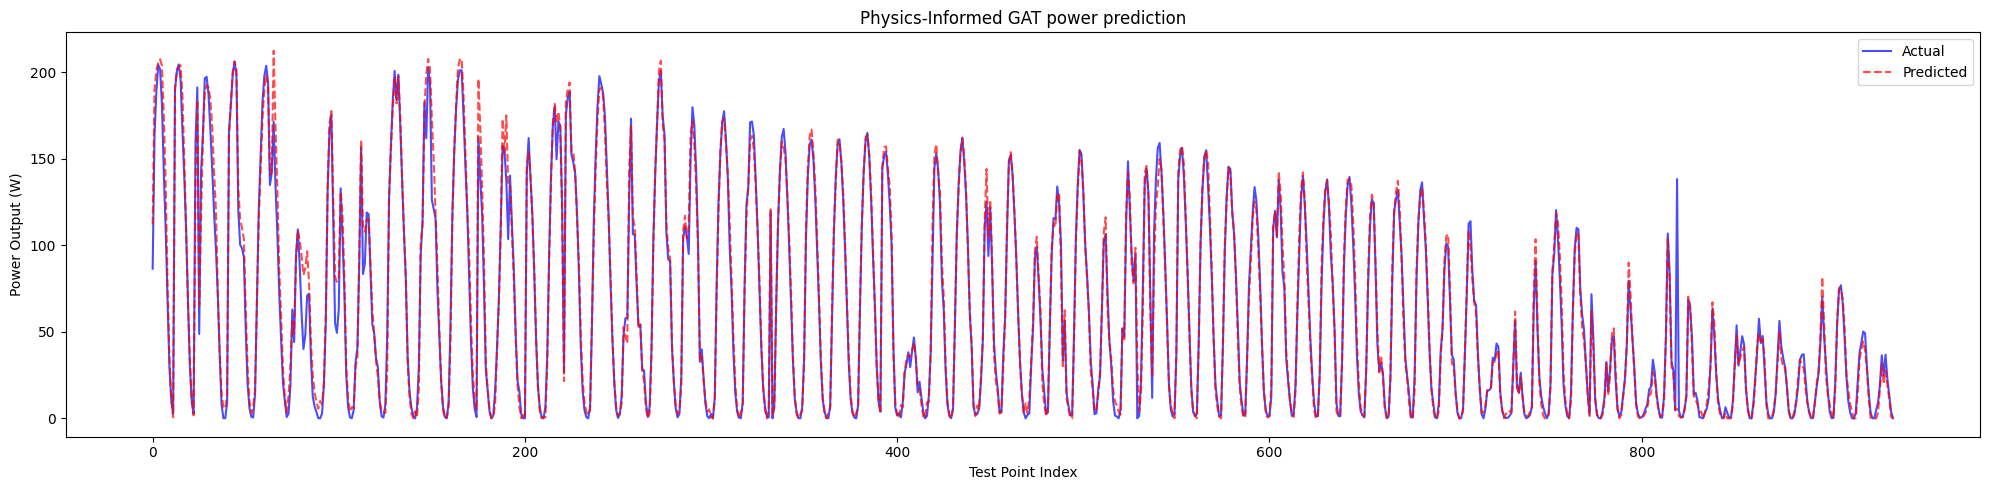

In [22]:
results_df.to_csv("predictions_continual_edgeNorm_tanH.csv", index=False)

mae = np.mean(np.abs(results_df['P_actual'] - results_df['P_predicted']))
print(f"\n=== FINAL RESULTS WITH EDGE NORMALIZATION ===")
print(f"MAE: {mae:.2f} W")

plt.figure(figsize=(20, 5))
plt.plot(results_df.index, results_df['P_actual'], label='Actual', color='blue', alpha=0.7)
plt.plot(results_df.index, results_df['P_predicted'], label='Predicted', color='red', linestyle='--', alpha=0.7)
plt.title("Physics-Informed GAT power prediction")
plt.xlabel("Test Point Index")
plt.ylabel("Power Output (W)")
plt.legend()
plt.tight_layout()
plt.savefig("prediction_plot_edgeNorm_tanH.png")
plt.show()

## Anomaly Detection

In [23]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv("GNN_vs_PVWATTS_benchmark.csv")

# 2. Compute Residuals
df["residual"] = df["P_actual"] - df["P_predicted"]
df['cos_incidence_angle'] = np.cos(np.radians(df['incidence angle']))
# ============================================================
# METHOD A: Physics-Informed Z-Score (Contextual)
# ============================================================

# Rolling window on the sequence index (handling gaps/short days automatically)
rolling_mean = df["residual"].rolling(window=15, min_periods=5, center=True).mean()
rolling_std = df["residual"].rolling(window=15, min_periods=5, center=True).std()

rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')
rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')

z_score = abs(df["residual"] - rolling_mean) / (rolling_std + 1e-6)

# Thresholds:
# 1. Statistical: Must be > 3 sigma away from neighbors
# 2. Practical: Must be > 10 Watts error (filters out tiny 1W noise at night)
# This catches "Zombie Sensors" (High Actual, Zero Predicted)
min_error_watts = 10.0
df["vote_physics"] = ((z_score > 3.0) & (abs(df["P_actual"]) > min_error_watts) & (abs(df["residual"]) > min_error_watts)).astype(int)

# ============================================================
# METHOD B & C: ML-Based Detection
# ============================================================

# We keep features that describe the system state and performance
ml_features = ["Gsw","T_PV", "T_air", "U", "deltaT", "eta", "P_actual", "residual", "q_HFM", 'cos_incidence_angle']

# Fill any tiny gaps (though filtered dataset should be clean)
X = df[ml_features].fillna(method='bfill').fillna(method='ffill')

# --- Method B: Isolation Forest ---
iso = IsolationForest(contamination=0.04, random_state=100, n_estimators=150)
df["vote_iso"] = ((iso.fit_predict(X) == -1)& (abs(df["P_actual"]) > min_error_watts)& (abs(df["residual"]) > min_error_watts)).astype(int)

# --- Method C: Local Outlier Factor (LOF) ---
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.04)
df["vote_lof"] = ((lof.fit_predict(X) == -1)& (abs(df["P_actual"]) > min_error_watts)& (abs(df["residual"]) > min_error_watts)).astype(int)

# ============================================================
# STEP 3: Majority Voting (Ensemble)
# ============================================================

df["anomaly_score"] = df["vote_physics"] + df["vote_iso"] + df["vote_lof"]

# Anomaly if at least 2 methods agree
df["anomaly_hybrid"] = df["anomaly_score"] >= 2

# ============================================================
# Summary & Save
# ============================================================
total_anomalies = df["anomaly_hybrid"].sum()
percent = (total_anomalies / len(df)) * 100

print(f"Total Data Points: {len(df)}")
print(f"Anomalies Detected: {total_anomalies} ({percent:.2f}%)")
print("-" * 30)
print("Breakdown by Method:")
print(f"Physics Flags: {df['vote_physics'].sum()}")
print(f"IsoForest Flags: {df['vote_iso'].sum()}")
print(f"LOF Flags: {df['vote_lof'].sum()}")

df.to_csv("GNN_PV_anomalies_hybrid.csv", index=False)
print("Saved to GNN_PV_anomalies_hybrid_final.csv")

Total Data Points: 936
Anomalies Detected: 8 (0.85%)
------------------------------
Breakdown by Method:
Physics Flags: 3
IsoForest Flags: 15
LOF Flags: 13
Saved to GNN_PV_anomalies_hybrid_final.csv


C:\Users\SM275008\AppData\Local\Temp\ipykernel_24352\1720189816.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')
C:\Users\SM275008\AppData\Local\Temp\ipykernel_24352\1720189816.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')
C:\Users\SM275008\AppData\Local\Temp\ipykernel_24352\1720189816.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[ml_features].fillna(method='bfill').fillna(method='ffill')


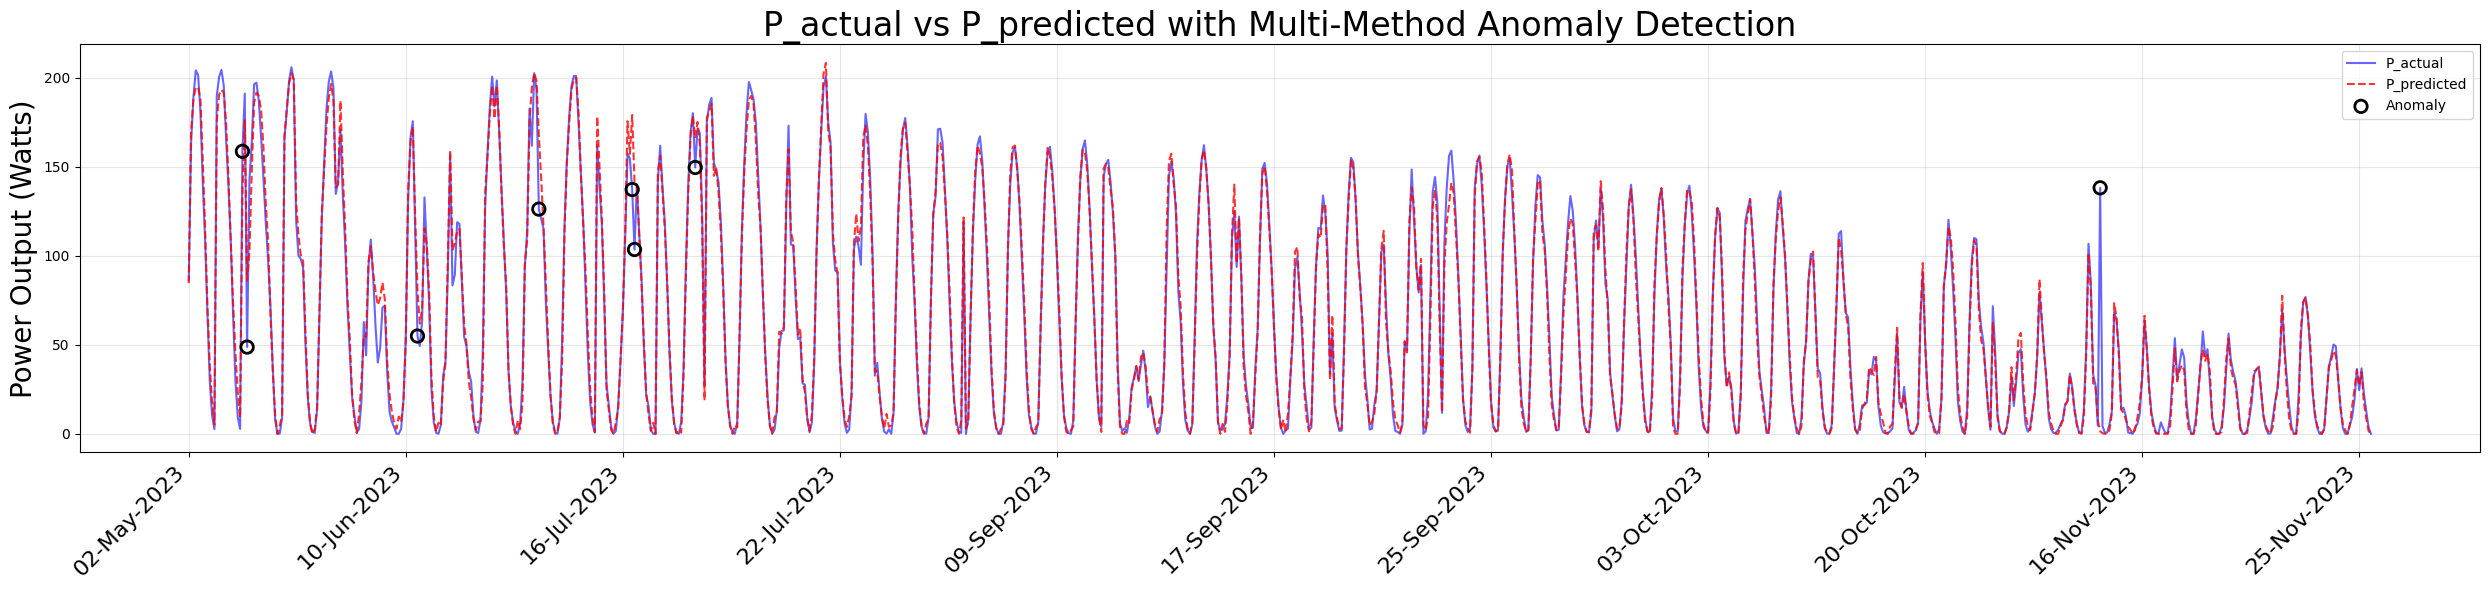

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("GNN_PV_anomalies_hybrid.csv")

# --- 1. Prepare Data ---

# A. Create the 'datetime' column (used for sorting and labeling)
df['datetime'] = pd.to_datetime(
    df['date'].astype(str) + ' ' + df['Hour_gnn'].astype(str) + ':00:00'
)

# B. Sort by date and then reset the index
# This is the key: we get a new, clean sequential index (0, 1, 2...)
df = df.sort_values(by='datetime').reset_index(drop=True)

# --- 2. Plotting using the SEQUENTIAL INDEX ---

plt.figure(figsize=(25, 6))

# Plot lines using df.index as the x-value
plt.plot(df.index, df['P_actual'], label='P_actual', color='blue', alpha=0.6)
plt.plot(df.index, df['P_predicted'], label='P_predicted', color='red', linestyle='--', alpha=0.8)

# --- PLOT ANOMALIES (Multi-Color) ---

# 1. Original GNN/Residual Anomalies (Black Circles)
if 'anomaly_hybrid' in df.columns:
    # Filter
    anom_gnn = df[df['anomaly_hybrid'].astype(bool) == True]
    # Plot
    plt.scatter(anom_gnn.index, anom_gnn['P_actual'], 
                color='black', label='Anomaly', 
                marker='o', s=80, facecolors='none', linewidths=2, zorder=5) 
    # Note: facecolors='none' makes an empty circle so you can see points inside it

# 2. Isolation Forest Anomalies (Cyan X's)
if 'iso_anomaly' in df.columns:
    anom_iso = df[df['iso_anomaly'].astype(bool) == True]
    plt.scatter(anom_iso.index, anom_iso['P_actual'], 
                color='cyan', label='Isolation Forest', 
                marker='x', s=80, linewidths=2, zorder=6)

# 3. Local Outlier Factor Anomalies (Magenta Triangles)
if 'lof_anomaly' in df.columns:
    anom_lof = df[df['lof_anomaly'].astype(bool) == True]
    plt.scatter(anom_lof.index, anom_lof['P_actual'], 
                color='magenta', label='Local Outlier Factor', 
                marker='^', s=60, zorder=7)

# --- 3. Format X-Axis with Date Labels ---
ax = plt.gca()

num_points = len(df)
tick_spacing = max(1, num_points // 10) 
            
tick_positions = np.arange(0, num_points, tick_spacing)

tick_labels = [
    df.iloc[i]['datetime'].strftime('%d-%b-%Y') 
    for i in tick_positions
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=16)

# --- 4. Final Touches ---
plt.title("P_actual vs P_predicted with Multi-Method Anomaly Detection", fontsize=24)
plt.ylabel("Power Output (Watts)", fontsize=20)
plt.legend(loc='upper right') # Moved legend to not block data
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd

# 1. Load the full results file from the previous step
input_file = "GNN_PV_anomalies_hybrid.csv"
output_file = "PI-GAT_detected_anomalies.csv"

print(f"Loading data from {input_file}...")
df = pd.read_csv(input_file)

# 2. Filter: Keep only the rows where the Hybrid Anomaly flag is True (or 1)
# This keeps all columns (weather, power, votes, etc.) for these specific points
anomalies_df = df[df["anomaly_hybrid"] == 1].copy()

# 3. Save the filtered dataset
anomalies_df.to_csv(output_file, index=False)

# 4. Print Summary
print("-" * 30)
print(f"Successfully saved {len(anomalies_df)} anomalies to '{output_file}'")
print("-" * 30)
print("Preview of anomalies:")
print(anomalies_df[["date", "Hour_gnn", "P_actual", "P_predicted", "residual", "anomaly_score"]])

Loading data from GNN_PV_anomalies_hybrid.csv...
------------------------------
Successfully saved 8 anomalies to 'PI-GAT_detected_anomalies.csv'
------------------------------
Preview of anomalies:
           date  Hour_gnn    P_actual  P_predicted    residual  anomaly_score
23   2023-06-01         7  158.733017   135.210205   23.522812              2
25   2023-06-01        16   48.748798    86.056229  -37.307430              2
98   2023-06-10        11   54.941830    80.266769  -25.324940              2
150  2023-07-13        12  126.263916   168.061142  -41.797226              2
190  2023-07-16        11  137.260391   179.145569  -41.885178              2
191  2023-07-16        12  103.575951   141.463699  -37.887749              2
217  2023-07-18        10  149.659164   166.152084  -16.492920              2
819  2023-10-28        10  138.234848     1.473259  136.761589              3
